# <b>Tokenization</b>

## **Introduction and Motivation**

Tokenization is at the heart of much weirdness of LLMs. Do not brush it off.

- Why can't LLM spell words? **Tokenization**.
- Why can't LLM do super simple string processing tasks like reversing a string? **Tokenization**.
- Why is LLM worse at non-English languages (e.g. Japanese)? **Tokenization**.
- Why is LLM bad at simple arithmetic? **Tokenization**.
- Why did GPT-2 have more than necessary trouble coding in Python? **Tokenization**.
- Why did my LLM abruptly halt when it sees the string "<|endoftext|>"? **Tokenization**.
- What is this weird warning I get about a "trailing whitespace"? **Tokenization**.
- Why the LLM break if I ask it about "SolidGoldMagikarp"? **Tokenization**.
- Why should I prefer to use YAML over JSON with LLMs? **Tokenization**.
- Why is LLM not actually end-to-end language modeling? **Tokenization**.
- What is the real root of suffering? **Tokenization**.

---

Good tokenization web app: [https://tiktokenizer.vercel.app](https://tiktokenizer.vercel.app)

Example string:

```
Tokenization is at the heart of much weirdness of LLMs. Do not brush it off.

127 + 677 = 804
1275 + 6773 = 8041

Egg.
I have an Egg.
egg.
EGG.

만나서 반가워요. 저는 OpenAI에서 개발한 대규모 언어 모델인 ChatGPT입니다. 궁금한 것이 있으시면 무엇이든 물어보세요.

for i in range(1, 101):
    if i % 3 == 0 and i % 5 == 0:
        print("FizzBuzz")
    elif i % 3 == 0:
        print("Fizz")
    elif i % 5 == 0:
        print("Buzz")
    else:
        print(i)
```

---

Much glory awaits someone who can delete the need for tokenization. But meanwhile, let's learn about it.

## **Data Preparation and Sampling to get Input Data "ready" for the LLM**

Packages that are being used in this notebook:

In [ ]:
from importlib.metadata import version

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.6.0+cu124
tiktoken version: 0.9.0


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/01.webp?timestamp=1" width="1000px">

### **Understanding Word Embeddings**

- There are many forms of embeddings; our focus is on text embeddings

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/02.webp" width="800px">

- LLMs work with embeddings in high-dimensional spaces (i.e., thousands of dimensions)
- Since we can't visualize such high-dimensional spaces (we humans think in 1, 2, or 3 dimensions), the figure below illustrates a 2-dimensional embedding space

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/03.webp" width="700px">

### **Tokenizing Text**

- In this section, we tokenize text, which means breaking text into smaller units, such as individual words and punctuation characters

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/04.webp" width="700px">

- Load raw text we want to work with
- [The Verdict by Edith Wharton](https://en.wikisource.org/wiki/The_Verdict) is a public domain short story

In [ ]:
import os
import urllib.request

if not os.path.exists("the-verdict.txt"):
    url = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
    file_path = "the-verdict.txt"
    urllib.request.urlretrieve(url, file_path)

- (If you encounter an `ssl.SSLCertVerificationError` when executing the previous code cell, it might be due to using an outdated Python version; you can find [more information here on GitHub](https://github.com/rasbt/LLMs-from-scratch/pull/403))

In [ ]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


- The goal is to tokenize and embed this text for an LLM
- Let's develop a simple tokenizer based on some simple sample text that we can then later apply to the text above
- The following regular expression will split on whitespaces

In [ ]:
import re

text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)

print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


- We don't only want to split on whitespaces but also commas and periods, so let's modify the regular expression to do that as well

In [ ]:
result = re.split(r'([,.]|\s)', text)

print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


- As we can see, this creates empty strings, let's remove them

In [ ]:
# Strip whitespace from each item and then filter out any empty strings.
result = [item for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


- This looks pretty good, but let's also handle other types of punctuation, such as periods, question marks, and so on

In [ ]:
text = "Hello, world. Is this-- a test?"

result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


- This is pretty good, and we are now ready to apply this tokenization to the raw text

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/05.webp" width="500px">

In [ ]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


- Let's calculate the total number of tokens

In [ ]:
print(len(preprocessed))

4690


### **Converting Tokens Into Token IDs**

- Next, we convert the text tokens into token IDs that we can process via embedding layers later

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/06.webp" width="800px">

- From these tokens, we can now build a vocabulary that consists of all the unique tokens

In [ ]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)

print(vocab_size)

1130


In [ ]:
vocab = {token:integer for integer,token in enumerate(all_words)}

- Below are the first 50 entries in this vocabulary:

In [ ]:
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


- Below, we illustrate the tokenization of a short sample text using a small vocabulary:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/07.webp?123" width="800px">

- Putting it now all together into a tokenizer class

In [ ]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)

        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

- The `encode` function turns text into token IDs
- The `decode` function turns token IDs back into text

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/08.webp?123" width="700px">

- We can use the tokenizer to encode (that is, tokenize) texts into integers
- These integers can then be embedded (later) as input of/for the LLM

In [ ]:
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know,"
           Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


- We can decode the integers back into text

In [ ]:
tokenizer.decode(ids)

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

In [ ]:
tokenizer.decode(tokenizer.encode(text))

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

### **Adding Special Context Tokens**

- It's useful to add some "special" tokens for unknown words and to denote the end of a text

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/09.webp?123" width="800px">

- Some tokenizers use special tokens to help the LLM with additional context
- Some of these special tokens are
  - `[BOS]` (beginning of sequence) marks the beginning of text
  - `[EOS]` (end of sequence) marks where the text ends (this is usually used to concatenate multiple unrelated texts, e.g., two different Wikipedia articles or two different books, and so on)
  - `[PAD]` (padding) if we train LLMs with a batch size greater than 1 (we may include multiple texts with different lengths; with the padding token we pad the shorter texts to the longest length so that all texts have an equal length)
- `[UNK]` to represent words that are not included in the vocabulary

- Note that GPT-2 does not need any of these tokens mentioned above but only uses an `<|endoftext|>` token to reduce complexity
- The `<|endoftext|>` is analogous to the `[EOS]` token mentioned above
- GPT also uses the `<|endoftext|>` for padding (since we typically use a mask when training on batched inputs, we would not attend padded tokens anyways, so it does not matter what these tokens are)
- GPT-2 does not use an `<UNK>` token for out-of-vocabulary words; instead, GPT-2 uses a byte-pair encoding (BPE) tokenizer, which breaks down words into subword units which we will discuss in a later section



- We use the `<|endoftext|>` tokens between two independent sources of text:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/10.webp" width="800px">

- Let's see what happens if we tokenize the following text:

In [ ]:
tokenizer = SimpleTokenizerV1(vocab)

text = "Hello, do you like tea. Is this-- a test?"

tokenizer.encode(text)

KeyError: 'Hello'

- The above produces an error because the word "Hello" is not contained in the vocabulary
- To deal with such cases, we can add special tokens like `"<|unk|>"` to the vocabulary to represent unknown words
- Since we are already extending the vocabulary, let's add another token called `"<|endoftext|>"` which is used in GPT-2 training to denote the end of a text (and it's also used between concatenated text, like if our training datasets consists of multiple articles, books, etc.)

In [ ]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer,token in enumerate(all_tokens)}

In [ ]:
len(vocab.items())

1132

In [ ]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


- We also need to adjust the tokenizer accordingly so that it knows when and how to use the new `<unk>` token

In [ ]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int
            else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

Let's try to tokenize text with the modified tokenizer:

In [ ]:
tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [ ]:
tokenizer.encode(text)

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]

In [ ]:
tokenizer.decode(tokenizer.encode(text))

'<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.'

### **BytePair Encoding (BPE)**

- GPT-2 used BytePair encoding (BPE) as its tokenizer
- It allows the model to break down words that aren't in its predefined vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words
- For instance, if GPT-2's vocabulary doesn't have the word "unfamiliarword," it might tokenize it as ["unfam", "iliar", "word"] or some other subword breakdown, depending on its trained BPE merges
- The original BPE tokenizer can be found here: [https://github.com/openai/gpt-2/blob/master/src/encoder.py](https://github.com/openai/gpt-2/blob/master/src/encoder.py)
- Here, we are using the BPE tokenizer from OpenAI's open-source [tiktoken](https://github.com/openai/tiktoken) library, which implements its core algorithms in Rust to improve computational performance
- See the [Byte Pair Encoding (BPE) Tokenizer From Scratch](https://github.com/rasbt/LLMs-from-scratch/blob/main/ch02/05_bpe-from-scratch/bpe-from-scratch.ipynb) notebook if you are interested in learning how the GPT-2 tokenizer can be implemented and trained from scratch.

In [ ]:
# pip install tiktoken

In [ ]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.9.0


In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

In [ ]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


In [ ]:
strings = tokenizer.decode(integers)

print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


- BPE tokenizers break down unknown words into subwords and individual characters:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/11.webp" width="700px">

### **Implementing a BPE Tokenizer from Scratch**

In [ ]:
"안녕하세요 👋 (hello in Korean!)"

'안녕하세요 👋 (hello in Korean!)'

In [ ]:
[ord(x)for x in "안녕하세요 👋 (hello in Korean!)"]

[50504,
 45397,
 54616,
 49464,
 50836,
 32,
 128075,
 32,
 40,
 104,
 101,
 108,
 108,
 111,
 32,
 105,
 110,
 32,
 75,
 111,
 114,
 101,
 97,
 110,
 33,
 41]

In [ ]:
list("안녕하세요 👋 (hello in Korean!)".encode("utf-8"))

[236,
 149,
 136,
 235,
 133,
 149,
 237,
 149,
 152,
 236,
 132,
 184,
 236,
 154,
 148,
 32,
 240,
 159,
 145,
 139,
 32,
 40,
 104,
 101,
 108,
 108,
 111,
 32,
 105,
 110,
 32,
 75,
 111,
 114,
 101,
 97,
 110,
 33,
 41]

In [ ]:
# text from https://www.reedbeta.com/blog/programmers-intro-to-unicode/
text = "Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception."
tokens = text.encode("utf-8") # raw bytes
tokens = list(map(int, tokens)) # convert to a list of integers in range 0..255 for convenience
print('---')
print(text)
print("length:", len(text))
print('---')
print(tokens)
print("length:", len(tokens))

---
Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception.
length: 533
---
[239, 188, 181, 239, 189, 142, 239, 189, 137, 239, 189, 131, 239, 189, 143, 239, 189, 132, 239, 189, 133, 33, 32, 240, 159, 133, 164, 240, 159, 133, 157, 240, 159, 133, 152, 240, 159, 133, 146, 240, 159, 133, 158, 240, 159, 133, 147, 240, 159, 133, 148, 226, 128, 189, 32, 240, 159, 135, 186, 226, 128, 140, 240, 159, 135, 179, 226, 128, 140, 240, 159, 135, 174, 226, 128, 140, 240, 159, 135, 168, 226, 128, 140, 240, 159, 135, 180, 226, 128, 140

In [ ]:
def get_stats(ids):
    counts = {}
    for pair in zip(ids, ids[1:]): # Pythonic way to iterate consecutive elements
        counts[pair] = counts.get(pair, 0) + 1
    return counts

stats = get_stats(tokens)

{(239, 188): 1, (188, 181): 1, (181, 239): 1, (239, 189): 6, (189, 142): 1, (142, 239): 1, (189, 137): 1, (137, 239): 1, (189, 131): 1, (131, 239): 1, (189, 143): 1, (143, 239): 1, (189, 132): 1, (132, 239): 1, (189, 133): 1, (133, 33): 1, (33, 32): 2, (32, 240): 3, (240, 159): 15, (159, 133): 7, (133, 164): 1, (164, 240): 1, (133, 157): 1, (157, 240): 1, (133, 152): 1, (152, 240): 1, (133, 146): 1, (146, 240): 1, (133, 158): 1, (158, 240): 1, (133, 147): 1, (147, 240): 1, (133, 148): 1, (148, 226): 1, (226, 128): 12, (128, 189): 1, (189, 32): 1, (159, 135): 7, (135, 186): 1, (186, 226): 1, (128, 140): 6, (140, 240): 6, (135, 179): 1, (179, 226): 1, (135, 174): 1, (174, 226): 1, (135, 168): 1, (168, 226): 1, (135, 180): 1, (180, 226): 1, (135, 169): 1, (169, 226): 1, (135, 170): 1, (170, 33): 1, (159, 152): 1, (152, 132): 1, (132, 32): 1, (32, 84): 1, (84, 104): 1, (104, 101): 6, (101, 32): 20, (32, 118): 1, (118, 101): 3, (101, 114): 6, (114, 121): 2, (121, 32): 2, (32, 110): 2, (110,

In [ ]:
print(stats)

{(239, 188): 1, (188, 181): 1, (181, 239): 1, (239, 189): 6, (189, 142): 1, (142, 239): 1, (189, 137): 1, (137, 239): 1, (189, 131): 1, (131, 239): 1, (189, 143): 1, (143, 239): 1, (189, 132): 1, (132, 239): 1, (189, 133): 1, (133, 33): 1, (33, 32): 2, (32, 240): 3, (240, 159): 15, (159, 133): 7, (133, 164): 1, (164, 240): 1, (133, 157): 1, (157, 240): 1, (133, 152): 1, (152, 240): 1, (133, 146): 1, (146, 240): 1, (133, 158): 1, (158, 240): 1, (133, 147): 1, (147, 240): 1, (133, 148): 1, (148, 226): 1, (226, 128): 12, (128, 189): 1, (189, 32): 1, (159, 135): 7, (135, 186): 1, (186, 226): 1, (128, 140): 6, (140, 240): 6, (135, 179): 1, (179, 226): 1, (135, 174): 1, (174, 226): 1, (135, 168): 1, (168, 226): 1, (135, 180): 1, (180, 226): 1, (135, 169): 1, (169, 226): 1, (135, 170): 1, (170, 33): 1, (159, 152): 1, (152, 132): 1, (132, 32): 1, (32, 84): 1, (84, 104): 1, (104, 101): 6, (101, 32): 20, (32, 118): 1, (118, 101): 3, (101, 114): 6, (114, 121): 2, (121, 32): 2, (32, 110): 2, (110,

In [ ]:
print(sorted(((v,k) for k,v in stats.items()), reverse=True))

[(20, (101, 32)), (15, (240, 159)), (12, (226, 128)), (12, (105, 110)), (10, (115, 32)), (10, (97, 110)), (10, (32, 97)), (9, (32, 116)), (8, (116, 104)), (7, (159, 135)), (7, (159, 133)), (7, (97, 114)), (6, (239, 189)), (6, (140, 240)), (6, (128, 140)), (6, (116, 32)), (6, (114, 32)), (6, (111, 114)), (6, (110, 103)), (6, (110, 100)), (6, (109, 101)), (6, (104, 101)), (6, (101, 114)), (6, (32, 105)), (5, (117, 115)), (5, (115, 116)), (5, (110, 32)), (5, (100, 101)), (5, (44, 32)), (5, (32, 115)), (4, (116, 105)), (4, (116, 101)), (4, (115, 44)), (4, (114, 105)), (4, (111, 117)), (4, (111, 100)), (4, (110, 116)), (4, (110, 105)), (4, (105, 99)), (4, (104, 97)), (4, (103, 32)), (4, (101, 97)), (4, (100, 32)), (4, (99, 111)), (4, (97, 109)), (4, (85, 110)), (4, (32, 119)), (4, (32, 111)), (4, (32, 102)), (4, (32, 85)), (3, (118, 101)), (3, (116, 115)), (3, (116, 114)), (3, (116, 111)), (3, (114, 116)), (3, (114, 115)), (3, (114, 101)), (3, (111, 102)), (3, (111, 32)), (3, (108, 108)), (

In [ ]:
top_pair = max(stats, key=stats.get)
top_pair

(101, 32)

In [ ]:
def merge(ids, pair, idx):
  # in the list of ints (ids), replace all consecutive occurences of pair with the new token idx
  newids = []
  i = 0
  while i < len(ids):
    # if we are not at the very last position AND the pair matches, replace it
    if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
      newids.append(idx)
      i += 2
    else:
      newids.append(ids[i])
      i += 1
  return newids

print(merge([5, 6, 6, 7, 9, 1], (6, 7), 99))

tokens2 = merge(tokens, top_pair, 256)
print(tokens2)
print("length:", len(tokens2))

[5, 6, 99, 9, 1]
[239, 188, 181, 239, 189, 142, 239, 189, 137, 239, 189, 131, 239, 189, 143, 239, 189, 132, 239, 189, 133, 33, 32, 240, 159, 133, 164, 240, 159, 133, 157, 240, 159, 133, 152, 240, 159, 133, 146, 240, 159, 133, 158, 240, 159, 133, 147, 240, 159, 133, 148, 226, 128, 189, 32, 240, 159, 135, 186, 226, 128, 140, 240, 159, 135, 179, 226, 128, 140, 240, 159, 135, 174, 226, 128, 140, 240, 159, 135, 168, 226, 128, 140, 240, 159, 135, 180, 226, 128, 140, 240, 159, 135, 169, 226, 128, 140, 240, 159, 135, 170, 33, 32, 240, 159, 152, 132, 32, 84, 104, 256, 118, 101, 114, 121, 32, 110, 97, 109, 256, 115, 116, 114, 105, 107, 101, 115, 32, 102, 101, 97, 114, 32, 97, 110, 100, 32, 97, 119, 256, 105, 110, 116, 111, 32, 116, 104, 256, 104, 101, 97, 114, 116, 115, 32, 111, 102, 32, 112, 114, 111, 103, 114, 97, 109, 109, 101, 114, 115, 32, 119, 111, 114, 108, 100, 119, 105, 100, 101, 46, 32, 87, 256, 97, 108, 108, 32, 107, 110, 111, 119, 32, 119, 256, 111, 117, 103, 104, 116, 32, 116, 111, 

In [ ]:
# making the training text longer to have more representative token statistics
# text from https://www.reedbeta.com/blog/programmers-intro-to-unicode/
text = """A Programmer’s Introduction to Unicode March 3, 2017 · Coding · 22 Comments  Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺\u200c🇳\u200c🇮\u200c🇨\u200c🇴\u200c🇩\u200c🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception.  A few months ago, I got interested in Unicode and decided to spend some time learning more about it in detail. In this article, I’ll give an introduction to it from a programmer’s point of view.  I’m going to focus on the character set and what’s involved in working with strings and files of Unicode text. However, in this article I’m not going to talk about fonts, text layout/shaping/rendering, or localization in detail—those are separate issues, beyond my scope (and knowledge) here.  Diversity and Inherent Complexity The Unicode Codespace Codespace Allocation Scripts Usage Frequency Encodings UTF-8 UTF-16 Combining Marks Canonical Equivalence Normalization Forms Grapheme Clusters And More… Diversity and Inherent Complexity As soon as you start to study Unicode, it becomes clear that it represents a large jump in complexity over character sets like ASCII that you may be more familiar with. It’s not just that Unicode contains a much larger number of characters, although that’s part of it. Unicode also has a great deal of internal structure, features, and special cases, making it much more than what one might expect a mere “character set” to be. We’ll see some of that later in this article.  When confronting all this complexity, especially as an engineer, it’s hard not to find oneself asking, “Why do we need all this? Is this really necessary? Couldn’t it be simplified?”  However, Unicode aims to faithfully represent the entire world’s writing systems. The Unicode Consortium’s stated goal is “enabling people around the world to use computers in any language”. And as you might imagine, the diversity of written languages is immense! To date, Unicode supports 135 different scripts, covering some 1100 languages, and there’s still a long tail of over 100 unsupported scripts, both modern and historical, which people are still working to add.  Given this enormous diversity, it’s inevitable that representing it is a complicated project. Unicode embraces that diversity, and accepts the complexity inherent in its mission to include all human writing systems. It doesn’t make a lot of trade-offs in the name of simplification, and it makes exceptions to its own rules where necessary to further its mission.  Moreover, Unicode is committed not just to supporting texts in any single language, but also to letting multiple languages coexist within one text—which introduces even more complexity.  Most programming languages have libraries available to handle the gory low-level details of text manipulation, but as a programmer, you’ll still need to know about certain Unicode features in order to know when and how to apply them. It may take some time to wrap your head around it all, but don’t be discouraged—think about the billions of people for whom your software will be more accessible through supporting text in their language. Embrace the complexity!  The Unicode Codespace Let’s start with some general orientation. The basic elements of Unicode—its “characters”, although that term isn’t quite right—are called code points. Code points are identified by number, customarily written in hexadecimal with the prefix “U+”, such as U+0041 “A” latin capital letter a or U+03B8 “θ” greek small letter theta. Each code point also has a short name, and quite a few other properties, specified in the Unicode Character Database.  The set of all possible code points is called the codespace. The Unicode codespace consists of 1,114,112 code points. However, only 128,237 of them—about 12% of the codespace—are actually assigned, to date. There’s plenty of room for growth! Unicode also reserves an additional 137,468 code points as “private use” areas, which have no standardized meaning and are available for individual applications to define for their own purposes.  Codespace Allocation To get a feel for how the codespace is laid out, it’s helpful to visualize it. Below is a map of the entire codespace, with one pixel per code point. It’s arranged in tiles for visual coherence; each small square is 16×16 = 256 code points, and each large square is a “plane” of 65,536 code points. There are 17 planes altogether.  Map of the Unicode codespace (click to zoom)  White represents unassigned space. Blue is assigned code points, green is private-use areas, and the small red area is surrogates (more about those later). As you can see, the assigned code points are distributed somewhat sparsely, but concentrated in the first three planes.  Plane 0 is also known as the “Basic Multilingual Plane”, or BMP. The BMP contains essentially all the characters needed for modern text in any script, including Latin, Cyrillic, Greek, Han (Chinese), Japanese, Korean, Arabic, Hebrew, Devanagari (Indian), and many more.  (In the past, the codespace was just the BMP and no more—Unicode was originally conceived as a straightforward 16-bit encoding, with only 65,536 code points. It was expanded to its current size in 1996. However, the vast majority of code points in modern text belong to the BMP.)  Plane 1 contains historical scripts, such as Sumerian cuneiform and Egyptian hieroglyphs, as well as emoji and various other symbols. Plane 2 contains a large block of less-common and historical Han characters. The remaining planes are empty, except for a small number of rarely-used formatting characters in Plane 14; planes 15–16 are reserved entirely for private use.  Scripts Let’s zoom in on the first three planes, since that’s where the action is:  Map of scripts in Unicode planes 0–2 (click to zoom)  This map color-codes the 135 different scripts in Unicode. You can see how Han () and Korean () take up most of the range of the BMP (the left large square). By contrast, all of the European, Middle Eastern, and South Asian scripts fit into the first row of the BMP in this diagram.  Many areas of the codespace are adapted or copied from earlier encodings. For example, the first 128 code points of Unicode are just a copy of ASCII. This has clear benefits for compatibility—it’s easy to losslessly convert texts from smaller encodings into Unicode (and the other direction too, as long as no characters outside the smaller encoding are used).  Usage Frequency One more interesting way to visualize the codespace is to look at the distribution of usage—in other words, how often each code point is actually used in real-world texts. Below is a heat map of planes 0–2 based on a large sample of text from Wikipedia and Twitter (all languages). Frequency increases from black (never seen) through red and yellow to white.  Heat map of code point usage frequency in Unicode planes 0–2 (click to zoom)  You can see that the vast majority of this text sample lies in the BMP, with only scattered usage of code points from planes 1–2. The biggest exception is emoji, which show up here as the several bright squares in the bottom row of plane 1.  Encodings We’ve seen that Unicode code points are abstractly identified by their index in the codespace, ranging from U+0000 to U+10FFFF. But how do code points get represented as bytes, in memory or in a file?  The most convenient, computer-friendliest (and programmer-friendliest) thing to do would be to just store the code point index as a 32-bit integer. This works, but it consumes 4 bytes per code point, which is sort of a lot. Using 32-bit ints for Unicode will cost you a bunch of extra storage, memory, and performance in bandwidth-bound scenarios, if you work with a lot of text.  Consequently, there are several more-compact encodings for Unicode. The 32-bit integer encoding is officially called UTF-32 (UTF = “Unicode Transformation Format”), but it’s rarely used for storage. At most, it comes up sometimes as a temporary internal representation, for examining or operating on the code points in a string.  Much more commonly, you’ll see Unicode text encoded as either UTF-8 or UTF-16. These are both variable-length encodings, made up of 8-bit or 16-bit units, respectively. In these schemes, code points with smaller index values take up fewer bytes, which saves a lot of memory for typical texts. The trade-off is that processing UTF-8/16 texts is more programmatically involved, and likely slower.  UTF-8 In UTF-8, each code point is stored using 1 to 4 bytes, based on its index value.  UTF-8 uses a system of binary prefixes, in which the high bits of each byte mark whether it’s a single byte, the beginning of a multi-byte sequence, or a continuation byte; the remaining bits, concatenated, give the code point index. This table shows how it works:  UTF-8 (binary)\tCode point (binary)\tRange 0xxxxxxx\txxxxxxx\tU+0000–U+007F 110xxxxx 10yyyyyy\txxxxxyyyyyy\tU+0080–U+07FF 1110xxxx 10yyyyyy 10zzzzzz\txxxxyyyyyyzzzzzz\tU+0800–U+FFFF 11110xxx 10yyyyyy 10zzzzzz 10wwwwww\txxxyyyyyyzzzzzzwwwwww\tU+10000–U+10FFFF A handy property of UTF-8 is that code points below 128 (ASCII characters) are encoded as single bytes, and all non-ASCII code points are encoded using sequences of bytes 128–255. This has a couple of nice consequences. First, any strings or files out there that are already in ASCII can also be interpreted as UTF-8 without any conversion. Second, lots of widely-used string programming idioms—such as null termination, or delimiters (newlines, tabs, commas, slashes, etc.)—will just work on UTF-8 strings. ASCII bytes never occur inside the encoding of non-ASCII code points, so searching byte-wise for a null terminator or a delimiter will do the right thing.  Thanks to this convenience, it’s relatively simple to extend legacy ASCII programs and APIs to handle UTF-8 strings. UTF-8 is very widely used in the Unix/Linux and Web worlds, and many programmers argue UTF-8 should be the default encoding everywhere.  However, UTF-8 isn’t a drop-in replacement for ASCII strings in all respects. For instance, code that iterates over the “characters” in a string will need to decode UTF-8 and iterate over code points (or maybe grapheme clusters—more about those later), not bytes. When you measure the “length” of a string, you’ll need to think about whether you want the length in bytes, the length in code points, the width of the text when rendered, or something else.  UTF-16 The other encoding that you’re likely to encounter is UTF-16. It uses 16-bit words, with each code point stored as either 1 or 2 words.  Like UTF-8, we can express the UTF-16 encoding rules in the form of binary prefixes:  UTF-16 (binary)\tCode point (binary)\tRange xxxxxxxxxxxxxxxx\txxxxxxxxxxxxxxxx\tU+0000–U+FFFF 110110xxxxxxxxxx 110111yyyyyyyyyy\txxxxxxxxxxyyyyyyyyyy + 0x10000\tU+10000–U+10FFFF A more common way that people talk about UTF-16 encoding, though, is in terms of code points called “surrogates”. All the code points in the range U+D800–U+DFFF—or in other words, the code points that match the binary prefixes 110110 and 110111 in the table above—are reserved specifically for UTF-16 encoding, and don’t represent any valid characters on their own. They’re only meant to occur in the 2-word encoding pattern above, which is called a “surrogate pair”. Surrogate code points are illegal in any other context! They’re not allowed in UTF-8 or UTF-32 at all.  Historically, UTF-16 is a descendant of the original, pre-1996 versions of Unicode, in which there were only 65,536 code points. The original intention was that there would be no different “encodings”; Unicode was supposed to be a straightforward 16-bit character set. Later, the codespace was expanded to make room for a long tail of less-common (but still important) Han characters, which the Unicode designers didn’t originally plan for. Surrogates were then introduced, as—to put it bluntly—a kludge, allowing 16-bit encodings to access the new code points.  Today, Javascript uses UTF-16 as its standard string representation: if you ask for the length of a string, or iterate over it, etc., the result will be in UTF-16 words, with any code points outside the BMP expressed as surrogate pairs. UTF-16 is also used by the Microsoft Win32 APIs; though Win32 supports either 8-bit or 16-bit strings, the 8-bit version unaccountably still doesn’t support UTF-8—only legacy code-page encodings, like ANSI. This leaves UTF-16 as the only way to get proper Unicode support in Windows. (Update: in Win10 version 1903, they finally added UTF-8 support to the 8-bit APIs! 😊)  By the way, UTF-16’s words can be stored either little-endian or big-endian. Unicode has no opinion on that issue, though it does encourage the convention of putting U+FEFF zero width no-break space at the top of a UTF-16 file as a byte-order mark, to disambiguate the endianness. (If the file doesn’t match the system’s endianness, the BOM will be decoded as U+FFFE, which isn’t a valid code point.)  Combining Marks In the story so far, we’ve been focusing on code points. But in Unicode, a “character” can be more complicated than just an individual code point!  Unicode includes a system for dynamically composing characters, by combining multiple code points together. This is used in various ways to gain flexibility without causing a huge combinatorial explosion in the number of code points.  In European languages, for example, this shows up in the application of diacritics to letters. Unicode supports a wide range of diacritics, including acute and grave accents, umlauts, cedillas, and many more. All these diacritics can be applied to any letter of any alphabet—and in fact, multiple diacritics can be used on a single letter.  If Unicode tried to assign a distinct code point to every possible combination of letter and diacritics, things would rapidly get out of hand. Instead, the dynamic composition system enables you to construct the character you want, by starting with a base code point (the letter) and appending additional code points, called “combining marks”, to specify the diacritics. When a text renderer sees a sequence like this in a string, it automatically stacks the diacritics over or under the base letter to create a composed character.  For example, the accented character “Á” can be expressed as a string of two code points: U+0041 “A” latin capital letter a plus U+0301 “◌́” combining acute accent. This string automatically gets rendered as a single character: “Á”.  Now, Unicode does also include many “precomposed” code points, each representing a letter with some combination of diacritics already applied, such as U+00C1 “Á” latin capital letter a with acute or U+1EC7 “ệ” latin small letter e with circumflex and dot below. I suspect these are mostly inherited from older encodings that were assimilated into Unicode, and kept around for compatibility. In practice, there are precomposed code points for most of the common letter-with-diacritic combinations in European-script languages, so they don’t use dynamic composition that much in typical text.  Still, the system of combining marks does allow for an arbitrary number of diacritics to be stacked on any base character. The reductio-ad-absurdum of this is Zalgo text, which works by ͖͟ͅr͞aṋ̫̠̖͈̗d͖̻̹óm̪͙͕̗̝ļ͇̰͓̳̫ý͓̥̟͍ ̕s̫t̫̱͕̗̰̼̘͜a̼̩͖͇̠͈̣͝c̙͍k̖̱̹͍͘i̢n̨̺̝͇͇̟͙ģ̫̮͎̻̟ͅ ̕n̼̺͈͞u̮͙m̺̭̟̗͞e̞͓̰̤͓̫r̵o̖ṷs҉̪͍̭̬̝̤ ̮͉̝̞̗̟͠d̴̟̜̱͕͚i͇̫̼̯̭̜͡ḁ͙̻̼c̲̲̹r̨̠̹̣̰̦i̱t̤̻̤͍͙̘̕i̵̜̭̤̱͎c̵s ͘o̱̲͈̙͖͇̲͢n͘ ̜͈e̬̲̠̩ac͕̺̠͉h̷̪ ̺̣͖̱ḻ̫̬̝̹ḙ̙̺͙̭͓̲t̞̞͇̲͉͍t̷͔̪͉̲̻̠͙e̦̻͈͉͇r͇̭̭̬͖,̖́ ̜͙͓̣̭s̘̘͈o̱̰̤̲ͅ ̛̬̜̙t̼̦͕̱̹͕̥h̳̲͈͝ͅa̦t̻̲ ̻̟̭̦̖t̛̰̩h̠͕̳̝̫͕e͈̤̘͖̞͘y҉̝͙ ̷͉͔̰̠o̞̰v͈͈̳̘͜er̶f̰͈͔ḻ͕̘̫̺̲o̲̭͙͠ͅw̱̳̺ ͜t̸h͇̭͕̳͍e̖̯̟̠ ͍̞̜͔̩̪͜ļ͎̪̲͚i̝̲̹̙̩̹n̨̦̩̖ḙ̼̲̼͢ͅ ̬͝s̼͚̘̞͝p͙̘̻a̙c҉͉̜̤͈̯̖i̥͡n̦̠̱͟g̸̗̻̦̭̮̟ͅ ̳̪̠͖̳̯̕a̫͜n͝d͡ ̣̦̙ͅc̪̗r̴͙̮̦̹̳e͇͚̞͔̹̫͟a̙̺̙ț͔͎̘̹ͅe̥̩͍ a͖̪̜̮͙̹n̢͉̝ ͇͉͓̦̼́a̳͖̪̤̱p̖͔͔̟͇͎͠p̱͍̺ę̲͎͈̰̲̤̫a̯͜r̨̮̫̣̘a̩̯͖n̹̦̰͎̣̞̞c̨̦̱͔͎͍͖e̬͓͘ ̤̰̩͙̤̬͙o̵̼̻̬̻͇̮̪f̴ ̡̙̭͓͖̪̤“̸͙̠̼c̳̗͜o͏̼͙͔̮r̞̫̺̞̥̬ru̺̻̯͉̭̻̯p̰̥͓̣̫̙̤͢t̳͍̳̖ͅi̶͈̝͙̼̙̹o̡͔n̙̺̹̖̩͝ͅ”̨̗͖͚̩.̯͓  A few other places where dynamic character composition shows up in Unicode:  Vowel-pointing notation in Arabic and Hebrew. In these languages, words are normally spelled with some of their vowels left out. They then have diacritic notation to indicate the vowels (used in dictionaries, language-teaching materials, children’s books, and such). These diacritics are expressed with combining marks.  A Hebrew example, with niqqud:\tאֶת דַלְתִּי הֵזִיז הֵנִיעַ, קֶטֶב לִשְׁכַּתִּי יָשׁוֹד Normal writing (no niqqud):\tאת דלתי הזיז הניע, קטב לשכתי ישוד Devanagari, the script used to write Hindi, Sanskrit, and many other South Asian languages, expresses certain vowels as combining marks attached to consonant letters. For example, “ह” + “\u200bि” = “हि” (“h” + “i” = “hi”). Korean characters stand for syllables, but they are composed of letters called jamo that stand for the vowels and consonants in the syllable. While there are code points for precomposed Korean syllables, it’s also possible to dynamically compose them by concatenating their jamo. For example, “ᄒ” + “ᅡ” + “ᆫ” = “한” (“h” + “a” + “n” = “han”). Canonical Equivalence In Unicode, precomposed characters exist alongside the dynamic composition system. A consequence of this is that there are multiple ways to express “the same” string—different sequences of code points that result in the same user-perceived characters. For example, as we saw earlier, we can express the character “Á” either as the single code point U+00C1, or as the string of two code points U+0041 U+0301.  Another source of ambiguity is the ordering of multiple diacritics in a single character. Diacritic order matters visually when two diacritics apply to the same side of the base character, e.g. both above: “ǡ” (dot, then macron) is different from “ā̇” (macron, then dot). However, when diacritics apply to different sides of the character, e.g. one above and one below, then the order doesn’t affect rendering. Moreover, a character with multiple diacritics might have one of the diacritics precomposed and others expressed as combining marks.  For example, the Vietnamese letter “ệ” can be expressed in five different ways:  Fully precomposed: U+1EC7 “ệ” Partially precomposed: U+1EB9 “ẹ” + U+0302 “◌̂” Partially precomposed: U+00EA “ê” + U+0323 “◌̣” Fully decomposed: U+0065 “e” + U+0323 “◌̣” + U+0302 “◌̂” Fully decomposed: U+0065 “e” + U+0302 “◌̂” + U+0323 “◌̣” Unicode refers to set of strings like this as “canonically equivalent”. Canonically equivalent strings are supposed to be treated as identical for purposes of searching, sorting, rendering, text selection, and so on. This has implications for how you implement operations on text. For example, if an app has a “find in file” operation and the user searches for “ệ”, it should, by default, find occurrences of any of the five versions of “ệ” above!  Normalization Forms To address the problem of “how to handle canonically equivalent strings”, Unicode defines several normalization forms: ways of converting strings into a canonical form so that they can be compared code-point-by-code-point (or byte-by-byte).  The “NFD” normalization form fully decomposes every character down to its component base and combining marks, taking apart any precomposed code points in the string. It also sorts the combining marks in each character according to their rendered position, so e.g. diacritics that go below the character come before the ones that go above the character. (It doesn’t reorder diacritics in the same rendered position, since their order matters visually, as previously mentioned.)  The “NFC” form, conversely, puts things back together into precomposed code points as much as possible. If an unusual combination of diacritics is called for, there may not be any precomposed code point for it, in which case NFC still precomposes what it can and leaves any remaining combining marks in place (again ordered by rendered position, as in NFD).  There are also forms called NFKD and NFKC. The “K” here refers to compatibility decompositions, which cover characters that are “similar” in some sense but not visually identical. However, I’m not going to cover that here.  Grapheme Clusters As we’ve seen, Unicode contains various cases where a thing that a user thinks of as a single “character” might actually be made up of multiple code points under the hood. Unicode formalizes this using the notion of a grapheme cluster: a string of one or more code points that constitute a single “user-perceived character”.  UAX #29 defines the rules for what, precisely, qualifies as a grapheme cluster. It’s approximately “a base code point followed by any number of combining marks”, but the actual definition is a bit more complicated; it accounts for things like Korean jamo, and emoji ZWJ sequences.  The main thing grapheme clusters are used for is text editing: they’re often the most sensible unit for cursor placement and text selection boundaries. Using grapheme clusters for these purposes ensures that you can’t accidentally chop off some diacritics when you copy-and-paste text, that left/right arrow keys always move the cursor by one visible character, and so on.  Another place where grapheme clusters are useful is in enforcing a string length limit—say, on a database field. While the true, underlying limit might be something like the byte length of the string in UTF-8, you wouldn’t want to enforce that by just truncating bytes. At a minimum, you’d want to “round down” to the nearest code point boundary; but even better, round down to the nearest grapheme cluster boundary. Otherwise, you might be corrupting the last character by cutting off a diacritic, or interrupting a jamo sequence or ZWJ sequence.  And More… There’s much more that could be said about Unicode from a programmer’s perspective! I haven’t gotten into such fun topics as case mapping, collation, compatibility decompositions and confusables, Unicode-aware regexes, or bidirectional text. Nor have I said anything yet about implementation issues—how to efficiently store and look-up data about the sparsely-assigned code points, or how to optimize UTF-8 decoding, string comparison, or NFC normalization. Perhaps I’ll return to some of those things in future posts.  Unicode is a fascinating and complex system. It has a many-to-one mapping between bytes and code points, and on top of that a many-to-one (or, under some circumstances, many-to-many) mapping between code points and “characters”. It has oddball special cases in every corner. But no one ever claimed that representing all written languages was going to be easy, and it’s clear that we’re never going back to the bad old days of a patchwork of incompatible encodings.  Further reading:  The Unicode Standard UTF-8 Everywhere Manifesto Dark corners of Unicode by Eevee ICU (International Components for Unicode)—C/C++/Java libraries implementing many Unicode algorithms and related things Python 3 Unicode Howto Google Noto Fonts—set of fonts intended to cover all assigned code points"""

In [ ]:
tokens = text.encode("utf-8") # raw bytes
tokens = list(map(int, tokens)) # convert to a list of integers in range 0..255 for convenience

In [ ]:
def get_stats(ids):
    counts = {}
    for pair in zip(ids, ids[1:]):
        counts[pair] = counts.get(pair, 0) + 1
    return counts

def merge(ids, pair, idx):
  newids = []
  i = 0
  while i < len(ids):
    if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
      newids.append(idx)
      i += 2
    else:
      newids.append(ids[i])
      i += 1
  return newids

# ---
vocab_size = 276 # the desired final vocabulary size
num_merges = vocab_size - 256
ids = list(tokens) # copy so we don't destroy the original list

merges = {} # (int, int) -> int
for i in range(num_merges):
  stats = get_stats(ids)
  pair = max(stats, key=stats.get)
  idx = 256 + i
  print(f"merging {pair} into a new token {idx}")
  ids = merge(ids, pair, idx)
  merges[pair] = idx

merging (101, 32) into a new token 256
merging (105, 110) into a new token 257
merging (115, 32) into a new token 258
merging (116, 104) into a new token 259
merging (101, 114) into a new token 260
merging (99, 111) into a new token 261
merging (116, 32) into a new token 262
merging (226, 128) into a new token 263
merging (44, 32) into a new token 264
merging (97, 110) into a new token 265
merging (111, 114) into a new token 266
merging (100, 32) into a new token 267
merging (97, 114) into a new token 268
merging (101, 110) into a new token 269
merging (257, 103) into a new token 270
merging (261, 100) into a new token 271
merging (121, 32) into a new token 272
merging (46, 32) into a new token 273
merging (97, 108) into a new token 274
merging (259, 256) into a new token 275


In [ ]:
print("tokens length:", len(tokens))
print("ids length:", len(ids))
print(f"compression ratio: {len(tokens) / len(ids):.2f}X")

tokens length: 24597
ids length: 19438
compression ratio: 1.27X


Note, the Tokenizer is a completely separate, independent module from the LLM. It has its own training dataset of text (which could be different from that of the LLM), on which you train the vocabulary using the Byte Pair Encoding (BPE) algorithm. It then translates back and forth between raw text and sequences of tokens. The LLM later only ever sees the tokens and never directly deals with any text.

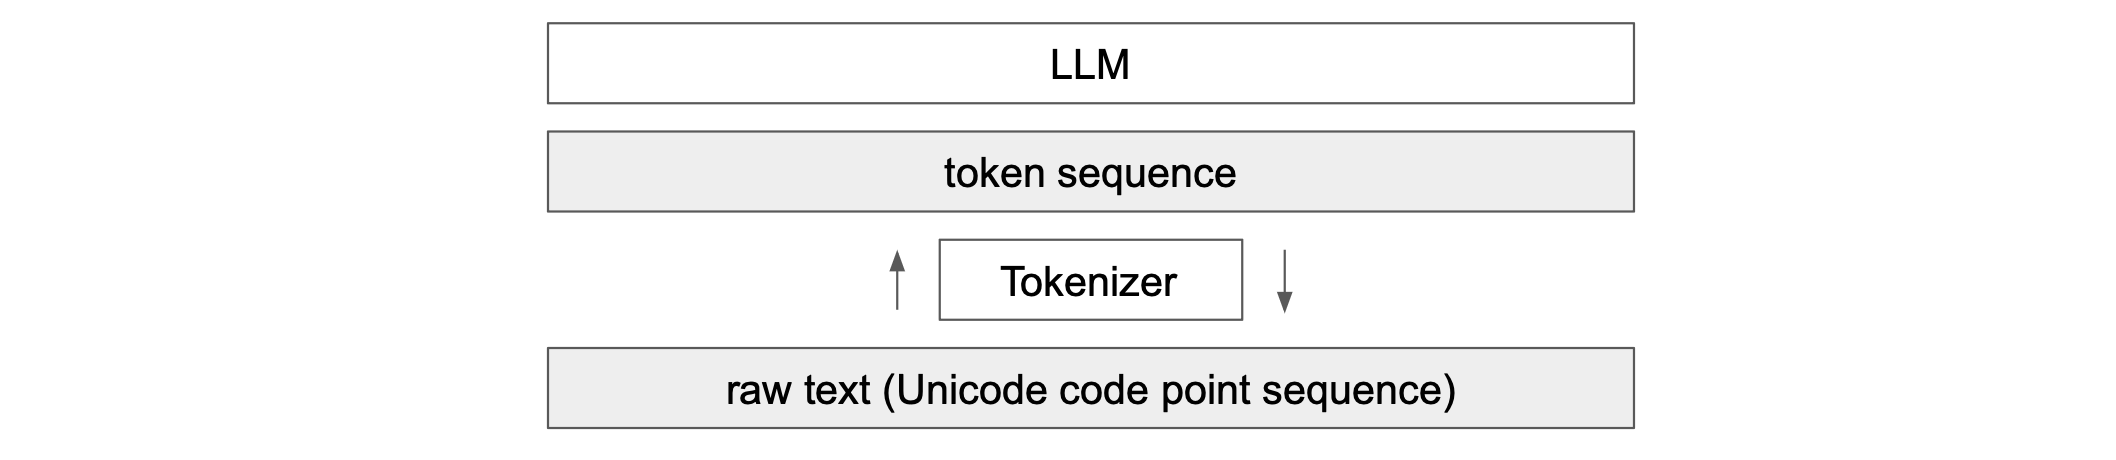

#### **Decoding**

Given a sequence of integers in the range [0, vocab_size], what is the text?


In [ ]:
vocab = {idx: bytes([idx]) for idx in range(256)}
for (p0, p1), idx in merges.items():
    vocab[idx] = vocab[p0] + vocab[p1]

def decode(ids):
  # given ids (list of integers), return Python string
  tokens = b"".join(vocab[idx] for idx in ids)
  text = tokens.decode("utf-8", errors="replace")
  return text

print(decode([128]))

�


#### **Encoding**

The other way around: Given a string, what are the tokens?


In [ ]:
merges

{(101, 32): 256,
 (105, 110): 257,
 (115, 32): 258,
 (116, 104): 259,
 (101, 114): 260,
 (99, 111): 261,
 (116, 32): 262,
 (226, 128): 263,
 (44, 32): 264,
 (97, 110): 265,
 (111, 114): 266,
 (100, 32): 267,
 (97, 114): 268,
 (101, 110): 269,
 (257, 103): 270,
 (261, 100): 271,
 (121, 32): 272,
 (46, 32): 273,
 (97, 108): 274,
 (259, 256): 275}

In [ ]:
def encode(text):
  # given a string, return list of integers (the tokens)
  tokens = list(text.encode("utf-8"))
  while len(tokens) >= 2:
    stats = get_stats(tokens)
    pair = min(stats, key=lambda p: merges.get(p, float("inf")))
    if pair not in merges:
      break # nothing else can be merged
    idx = merges[pair]
    tokens = merge(tokens, pair, idx)
  return tokens

print(encode(""))

[]


In [ ]:
print(decode(encode("hello world")))

hello world


In [ ]:
text2 = decode(encode(text))
print(text2 == text)

True


In [ ]:
valtext = "Many common characters, including numerals, punctuation, and other symbols, are unified within the standard and are not treated as specific to any given writing system. Unicode encodes thousands of emoji, with the continued development thereof conducted by the Consortium as a part of the standard.[4] Moreover, the widespread adoption of Unicode was in large part responsible for the initial popularization of emoji outside of Japan. Unicode is ultimately capable of encoding more than 1.1 million characters."
valtext2 = decode(encode(valtext))
print(valtext2 == valtext)

True


### **Data Sampling With a Sliding Window**

- We train LLMs to generate one word at a time, so we want to prepare the training data accordingly where the next word in a sequence represents the target to predict:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/12.webp" width="700px">

In [ ]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


- For each text chunk, we want the inputs and targets
- Since we want the model to predict the next word, the targets are the inputs shifted by one position to the right

In [ ]:
enc_sample = enc_text[50:]

In [ ]:
context_size = 4

x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

print(f"x: {x}")
print(f"y:      {y}")

x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


- One by one, the prediction would look like as follows:

In [ ]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


In [ ]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


- Now, we implement a simple data loader that iterates over the input dataset and returns the inputs and targets shifted by one

- Install and import PyTorch

In [ ]:
import torch
print("PyTorch version:", torch.__version__)

PyTorch version: 2.6.0+cu124


- We use a sliding window approach, changing the position by +1:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/13.webp?123" width="700px">

- Create dataset and dataloader that extract chunks from the input text dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        assert len(token_ids) > max_length, "Number of tokenized inputs must at least be equal to max_length+1"

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [ ]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

- Let's test the dataloader with a batch size of 1 for an LLM with a context size of 4:

In [ ]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

In [ ]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [ ]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


- An example using stride equal to the context length (here: 4) as shown below:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/14.webp" width="700px">

- We can also create batched outputs
- Note that we increase the stride here so that we don't have overlaps between the batches, since more overlap could lead to increased overfitting

In [ ]:
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


### **Creating Token Embeddings**

- The data is already almost ready for an LLM
- But lastly let us embed the tokens in a continuous vector representation using an embedding layer
- Usually, these embedding layers are part of the LLM itself and are updated (trained) during model training

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/15.webp" width="700px">

- Suppose we have the following four input examples with input ids 2, 3, 5, and 1 (after tokenization):

In [ ]:
input_ids = torch.tensor([2, 3, 5, 1])

In [ ]:
tokenizer.n_vocab

50257

- For the sake of simplicity, suppose we have a small vocabulary of only 6 words and we want to create embeddings of size 3:

In [ ]:
vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

- This would result in a 6x3 weight matrix:

In [ ]:
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


- For those who are familiar with one-hot encoding, the embedding layer approach above is essentially just a more efficient way of implementing one-hot encoding followed by matrix multiplication in a fully-connected layer, which is described [here](https://github.com/rasbt/LLMs-from-scratch/blob/main/ch02/03_bonus_embedding-vs-matmul/embeddings-and-linear-layers.ipynb)
- Because the embedding layer is just a more efficient implementation that is equivalent to the one-hot encoding and matrix-multiplication approach it can be seen as a neural network layer that can be optimized via backpropagation

- To convert a token with id 3 into a 3-dimensional vector, we do the following:

In [ ]:
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


- Note that the above is the 4th row in the `embedding_layer` weight matrix
- To embed all four `input_ids` values above, we do

In [ ]:
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


- An embedding layer is essentially a look-up operation:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/16.webp?123" width="700px">

### **Encoding Word Positions**

- Embedding layer convert IDs into identical vector representations regardless of where they are located in the input sequence:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/17.webp" width="700px">

- Positional embeddings are combined with the token embedding vector to form the input embeddings for a large language model:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/18.webp" width="800px">

- The BytePair encoder has a vocabulary size of 50,257:
- Suppose we want to encode the input tokens into a 256-dimensional vector representation:

In [ ]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

- If we sample data from the dataloader, we embed the tokens in each batch into a 256-dimensional vector
- If we have a batch size of 8 with 4 tokens each, this results in a 8 x 4 x 256 tensor:

In [ ]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
    stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

In [ ]:
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [ ]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

# uncomment & execute the following line to see how the embeddings look like
# print(token_embeddings)

torch.Size([8, 4, 256])


- GPT-2 uses absolute position embeddings, so we just create another embedding layer:

In [ ]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

# uncomment & execute the following line to see how the embedding layer weights look like
print(pos_embedding_layer.weight)

Parameter containing:
tensor([[ 1.9192, -0.0239, -1.3632,  ...,  1.0244,  0.6319, -0.2026],
        [ 1.0580, -0.1855,  0.5553,  ...,  0.0593, -1.2205,  0.7917],
        [ 0.3932,  0.1786, -0.4253,  ...,  1.4493, -0.8674,  0.8658],
        [ 0.4966, -1.9540, -1.0235,  ...,  1.1835,  1.0848,  0.1064]],
       requires_grad=True)


In [ ]:
torch.arange(max_length)

tensor([0, 1, 2, 3])

In [ ]:
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

# uncomment & execute the following line to see how the embeddings look like
print(pos_embeddings)

torch.Size([4, 256])
tensor([[-0.8194,  0.5543, -0.8290,  ...,  0.1325,  0.2115,  0.3610],
        [ 0.4193, -0.9461, -0.3407,  ...,  0.7930,  1.7009,  0.5663],
        [-0.2362, -1.7187, -1.0489,  ...,  1.1218,  0.2796,  0.9912],
        [-0.9549,  0.4699,  0.2580,  ..., -1.3689,  1.6505,  1.3488]],
       grad_fn=<EmbeddingBackward0>)


- To create the input embeddings used in an LLM, we simply add the token and the positional embeddings:

In [ ]:
token_embeddings.shape

torch.Size([8, 4, 256])

In [ ]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

# uncomment & execute the following line to see how the embeddings look like
print(input_embeddings)

torch.Size([8, 4, 256])
tensor([[[-0.3281,  1.6782,  0.6298,  ..., -0.2670, -1.6620,  0.2165],
         [ 0.8674, -0.6925, -0.6063,  ...,  1.2927,  0.5018, -0.6181],
         [-0.4869, -1.7733, -0.3802,  ...,  2.0836,  2.6533,  0.9384],
         [-0.0091,  1.3356,  1.8771,  ..., -1.8233,  0.9045,  1.6972]],

        [[ 0.7267,  2.2912, -1.6138,  ...,  0.0321,  1.0699,  0.0189],
         [-1.4429, -1.1375, -0.7219,  ...,  1.9150,  1.3513,  1.1754],
         [ 1.7486, -2.3669, -1.1904,  ...,  0.7377, -0.6559,  2.4390],
         [ 0.0099,  1.7672, -1.3627,  ..., -0.2226,  3.2302,  1.7457]],

        [[-1.5907,  1.2115, -0.6627,  ..., -0.6719,  0.2657,  1.1036],
         [ 1.2239, -0.4414,  0.9515,  ...,  2.2578,  2.1106,  0.8868],
         [-0.1567, -3.4823, -0.4740,  ...,  3.3041,  2.1027,  0.6277],
         [-0.5282,  0.4051,  0.8265,  ..., -1.8898,  2.9570,  2.1961]],

        ...,

        [[-2.4349,  1.5153, -3.4727,  ..., -0.8320,  1.3004,  1.9994],
         [ 0.0208, -1.8696, -1.65

- In the initial phase of the input processing workflow, the input text is segmented into separate tokens
- Following this segmentation, these tokens are transformed into token IDs based on a predefined vocabulary:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/19.webp" width="600px">

# **Running Pre-trained LLMs and Comparing LLM Tokenizers**



## **[OPTIONAL] - Installing Packages on** <img src="https://colab.google/static/images/icons/colab.png" width=100>

If you are viewing this notebook on Google Colab (or any other cloud vendor), you need to **uncomment and run** the following codeblock to install the dependencies for this section:

---

💡 **NOTE**: We will want to use a GPU to run the examples in this notebook. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---

In [ ]:
%%capture
!pip install --upgrade transformers==4.41.2 sentence-transformers==3.0.1 gensim==4.3.2 scikit-learn==1.5.0 accelerate==0.31.0 peft==0.11.1 scipy==1.10.1 numpy==1.26.4

## **Downloading and Running An LLM**

The first step is to load our model onto the GPU for faster inference. Note that we load the model and tokenizer separately and keep them as such so that we can explore them separately.

In [ ]:
from google.colab import userdata
HF_TOKEN = userdata.get('HF_TOKEN')

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=False,
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
prompt = "Write an email apologizing to Sarah for the tragic gardening mishap. Explain how it happened.<|assistant|>"

# Tokenize the input prompt
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")

# Generate the text
generation_output = model.generate(
  input_ids=input_ids,
  max_new_tokens=20
)

In [ ]:
print(input_ids)

tensor([[14350,   385,  4876, 27746,  5281,   304, 19235,   363,   278, 25305,
           293, 16423,   292,   286,   728,   481, 29889, 12027,  7420,   920,
           372,  9559, 29889, 32001]], device='cuda:0')


In [ ]:
for id in input_ids[0]:
   print(tokenizer.decode(id))

Write
an
email
apolog
izing
to
Sarah
for
the
trag
ic
garden
ing
m
ish
ap
.
Exp
lain
how
it
happened
.
<|assistant|>


In [ ]:
generation_output

tensor([[14350,   385,  4876, 27746,  5281,   304, 19235,   363,   278, 25305,
           293, 16423,   292,   286,   728,   481, 29889, 12027,  7420,   920,
           372,  9559, 29889, 32001,  3323,   622, 29901,   317,  3742,   406,
          6225, 11763,   363,   278, 19906,   292,   341,   728,   481,    13,
            13,    13, 29928,   799]], device='cuda:0')

In [ ]:
print(tokenizer.decode(generation_output[0]))

Write an email apologizing to Sarah for the tragic gardening mishap. Explain how it happened.<|assistant|> Subject: Sincere Apologies for the Gardening Mishap


Dear


In [ ]:
import torch

print(tokenizer.decode(torch.tensor(3323)))
print(tokenizer.decode(torch.tensor(622)))
print(tokenizer.decode(torch.tensor([3323, 622])))
print(tokenizer.decode(torch.tensor(29901)))

Sub
ject
Subject
:


## **Comparing Trained LLM Tokenizers**


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

colors_list = [
    '102;194;165', '252;141;98', '141;160;203',
    '231;138;195', '166;216;84', '255;217;47'
]

def show_tokens(sentence, tokenizer_name):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    token_ids = tokenizer(sentence).input_ids
    for idx, t in enumerate(token_ids):
        print(
            f'\x1b[0;30;48;2;{colors_list[idx % len(colors_list)]}m' +
            tokenizer.decode(t) +
            '\x1b[0m',
            end=' '
        )

In [ ]:
text = """
English and CAPITALIZATION
🎵 鸟
show_tokens False None elif == >= else: two tabs:"    " Three tabs: "       "
12.0*50=600
"""

In [ ]:
show_tokens(text, "bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

[CLS] english and capital ##ization [UNK] [UNK] show _ token ##s false none eli ##f = = > = else : two tab ##s : " " three tab ##s : " " 12 . 0 * 50 = 600 [SEP] 

In [ ]:
show_tokens(text, "bert-base-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

[CLS] English and CA ##PI ##TA ##L ##I ##Z ##AT ##ION [UNK] [UNK] show _ token ##s F ##als ##e None el ##if = = > = else : two ta ##bs : " " Three ta ##bs : " " 12 . 0 * 50 = 600 [SEP] 

In [ ]:
show_tokens(text, "gpt2")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


 English  and  CAP ITAL IZ ATION 
 � � �  � � � 
 show _ t ok ens  False  None  el if  ==  >=  else :  two  tabs :"        "  Three  tabs :  "              " 
 12 . 0 * 50 = 600 
 

In [ ]:
show_tokens(text, "google/flan-t5-small")

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

English and CA PI TAL IZ ATION  <unk>  <unk> show _ to ken s Fal s e None  e l if = = > = else : two tab s : " " Three tab s : " " 12. 0 * 50 = 600  </s> 

In [ ]:
# The official is `tiktoken` but this the same tokenizer on the HF platform
show_tokens(text, "Xenova/gpt-4")

tokenizer_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.



 English  and  CAPITAL IZATION 
 � � �  � � � 
 show _tokens  False  None  elif  ==  >=  else :  two  tabs :"      "  Three  tabs :  "         "
 12 . 0 * 50 = 600 
 

In [ ]:
# You need to request access before being able to use this tokenizer
show_tokens(text, "bigcode/starcoder2-15b")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]


 English  and  CAPITAL IZATION 
 � � �   � � 
 show _ tokens  False  None  elif  ==  >=  else :  two  tabs :"      "  Three  tabs :  "         " 
 1 2 . 0 * 5 0 = 6 0 0 
 

In [ ]:
show_tokens(text, "facebook/galactica-1.3b")

tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.00 [00:00<?, ?B/s]


 English  and  CAP ITAL IZATION 
 � � � �  � � � 
 show _ tokens  False  None  elif   ==   > =  else :  two  t abs : "      "  Three  t abs :   "         " 
 1 2 . 0 * 5 0 = 6 0 0 
 

In [ ]:
show_tokens(text, "microsoft/Phi-3-mini-4k-instruct")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


 
 English and C AP IT AL IZ ATION 
 � � � �  � � � 
 show _ to kens False None elif == >= else : two tabs :"    " Three tabs : "       " 
 1 2 . 0 * 5 0 = 6 0 0 
 

# **LLM Embeddings**

- Embeddings are the semantic backbone of LLMs, the gate at which raw text is transformed into vectors of numbers that are understandable by the model. When you prompt an LLM to help you debug your code, your words and tokens are transformed into a high-dimensional vector space where semantic relationships become mathematical relationships.

- In this section, we go through the fundamentals of embeddings. We will cover what embeddings are, how they evolved over time from statistical methods to modern techniques, check out how they're implemented in practice, look at some of the most important embedding techniques, and how the embeddings of an LLM (DeepSeek-R1-Distill-Qwen-1.5B) look like as a graph representation.

## **What are Embeddings?**

- Processing text for NLP tasks requires a numeric representation of each word. Most embedding methods come down to turning a word or token into a vector. What makes these techniques different from each other, is how they approach this word → vector conversion.

- Embedding is not just for text, they can be applied to images, audio, or even graph data. In a general sense, embedding is the process of converting data [of any type] into vectors.

- Almost every embedding technique relies on a corpus of text data to extract the relationship of the word.

- In this section, we talk about "text" embeddings, the techniques for which have evolved over time.

- **Static vs. Dynamic (or contextualized) Embeddings:**
    - **Token Embeddings are Static.** These are the fixed vectors assigned to input tokens at the very beginning of an LLM.
    - The representations produced by the **deeper layers of the model** are **Contextualized**.  As training progresses, the intermediate hidden states evolve as they pass through each layer, capturing the full context of the input.

<img src="https://i-blog.csdnimg.cn/direct/e995063f63e149a4b5ff4e1f8f6d4146.png" width="800px">

## **What Makes a Good Embedding?**

- **Quality of Semantic Representation**: Embeddings must capture the semantic relationships between words. Words with similar meanings should be placed close in the vector space and unrelated words must be set apart. The vectors of "cat" and "dog" must be more similar that "dog" and "barrel".

- **Dimensionality Efficiency**: How big must the embedding vectors be? 15, 50, 300? Striking the right balance is key. Smaller vectors (lower dimensions) are more efficient to keep in memory or to process, while bigger vectors (higher dimensions) can capture intricate relationships, but are also prone to overfitting. For reference, GPT-2 model family has an embedding size of at least 768.

## **TF-IDF (Term Frequency-Inverse Document Frequency):**

The idea of TF-IDF is to calculate the importance of a word in a document by considering two factors[1]:
1. **Term-Frequency (TF)**: How frequent a term appears in a document. A higher TF shows that a term is more important to the document.

2. **Inverse Document Frequency (IDF)**: How rare a term is across documents. This is based on the assumption that terms that appear in many of the documents are less important than terms that are unique to fewer documents.

$$
\text{tf}(t,d) = \begin{cases}
- 1 + \log_e(f_{t,d}) & \text{if } f_{t,d} > 0 \\
- 0 & \text{if } f_{t,d} = 0
\end{cases}
$$
where $f_{t,d}$ is the raw frequency of term $t$ in document $d$


$$
\text{idf}(t,\mathcal{D}) = \log\left(\frac{N + 1}{\text{df}(t) + 1}\right) + 1
$$
where:

- $t$ is a term in the vocabulary
- $\mathcal{D}$ is the corpus of documents
- $N$ is the total number of documents in $\mathcal{D}$
- $\text{df}(t)$ is the document frequency of term $t$


Now let's start use TF-IDF using the [TinyShakespeare](https://github.com/karpathy/char-rnn/blob/master/data/tinyshakespeare/input.txt) dataset.

In [ ]:
# load the dataset
with open("tinyshakespeare.txt", "r") as file:
    corpus = file.read()

print(f"Text corpus includes {len(corpus.split())} words.")

# to simulate multiple documents, we chunk up the corpus into 10 pieces
N = len(corpus) // 10
documents = [corpus[i:i+N] for i in range(0, len(corpus), N)]

documents = documents[:-1] #last document is residue
# now we have N documents from the corpus

Text corpus includes 202651 words.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
embeddings = vectorizer.fit_transform(documents)
words = vectorizer.get_feature_names_out()

print(f"Word count: {len(words)} e.g.: {words[:10]}")
print(f"Embedding shape: {embeddings.shape}")

Word count: 11446 e.g.: ['abandon' 'abase' 'abate' 'abated' 'abbey' 'abbot' 'abed' 'abel' 'abet'
 'abhor']
Embedding shape: (10, 11446)


let's now visualize the embeddings in 2d space.

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings.T)

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Create a DataFrame for plotting
df_plot = pd.DataFrame({
    'x': emb_2d[:, 0],
    'y': emb_2d[:, 1],
    'word': words
})

# Calculate distance from origin for color
df_plot['distance'] = np.sqrt(df_plot['x']**2 + df_plot['y']**2)

# Randomly sample 1000 points
sample_size = min(1500, len(df_plot))
df_sample = df_plot.sample(n=sample_size)

# Create the figure using graph_objects
fig = go.Figure(data=[
    go.Scatter(
        x=df_sample['x'],
        y=df_sample['y'],
        mode='markers+text',  # Explicitly set mode to show both markers and text
        text=df_sample['word'],
        textposition='top center',
        textfont=dict(
            color='rgba(0,0,0,0.5)'  # Semi-transparent black text
        ),
        marker=dict(
            size=6,
            opacity=0.7,
            color=df_sample['distance'],
            colorscale='plasma',
            showscale=False  # Hide the color scale
        ),
        hovertemplate='x: %{x:.2f}<br>y: %{y:.2f}<br>word: %{text}<extra></extra>'
    )
])

# Basic layout
fig.update_layout(
    coloraxis_showscale=False,
    width=800,
    height=600,
    showlegend=False,
    xaxis_title=None,
    yaxis_title=None,
    margin=dict(l=30, r=30, t=30, b=30),
    paper_bgcolor='white',
    )

# Show in notebook
fig.show()

# Save to HTML
fig.write_html(
    "tfidf-emb.html",
    include_plotlyjs='cdn',
    full_html=True
)

In [ ]:
# use plotly to visualize the embeddings
import plotly.express as px
import pandas as pd

# Create a DataFrame for plotting
df_plot = pd.DataFrame({
    'x': emb_2d[:, 0],
    'y': emb_2d[:, 1],
    'word': words
})

# Create scatter plot with text labels for all points
fig = px.scatter(
    df_plot,
    x='x',
    y='y',
    text='word',  # Show text labels for all points
    # hover_data=['word'],
    # color=np.sqrt(df_plot['x']**2 + df_plot['y']**2), # Use distance from origin for color
    # color_continuous_scale='plasma'  # Use plasma colorscale
)

# # Update traces to set text position and opacity
# fig.update_traces(
#     marker=dict(size=8, opacity=0.8),  # Increased opacity for dots
#     textposition='top center',
#     textfont=dict(size=10, color='black'),  # Increased text size and color,
#     hovertemplate='x: %{x:.2f}<br>y: %{y:.2f}<br>word: %{text}<extra></extra>' # Show x, y and word
# )

# fig.update_layout(
#     coloraxis_showscale=False,
#     width=800,
#     height=600,
#     showlegend=False,
#     xaxis_title=None,
#     yaxis_title=None,
#     margin=dict(l=30, r=30, t=30, b=30),
#     paper_bgcolor='white',
#     )

# # Update text opacity through layout annotations
# for trace in fig.data:
#     if trace.text is not None:  # Only update traces with text
#         trace.textfont.color = 'rgba(0,0,0,0.2)'  # Black with 0.3 opacity

fig.show()

import plotly.io as pio
pio.write_html(
    fig,
    file='tfidf-emb.html',
    auto_open=True,
    include_plotlyjs=True,
    full_html=True
)

# Save the plotly figure as HTML with interactive features enabled
# fig.write_html("tfidf-emb.html",
#                include_plotlyjs='cdn',
#                include_mathjax=False,
#                full_html=True,
#                auto_play=False,
#                config={'scrollZoom': True,
#                       'displayModeBar': True,
#                       'responsive':True}
#                 )

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
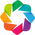

In [ ]:
import pandas as pd
import holoviews as hv
hv.extension('bokeh')

df = pd.DataFrame({
    'x': emb_2d[:, 0],
    'y': emb_2d[:, 1],
    'word': list(words)
})

# sample of words we are interested in
special_words = ['dog', 'cat', 'animal', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']
# show only 200 words that are not special, otherwhise the plot would be too dense
mask = df['word'].isin(special_words)
non_special_df = df[~mask].sample(n=200, random_state=42)
special_df = df[mask]
df = pd.concat([special_df, non_special_df])

# show special words in red
df['color'] = 'gray'
df.loc[df['word'].isin(special_words), 'color'] = 'red'

df['size'] = 5
df.loc[df['word'].isin(special_words), 'size'] = 15

# add label color column
df['label_color'] = 'gray'
df.loc[df['word'].isin(special_words), 'label_color'] = 'red'

points = hv.Points(df, kdims=['x', 'y'], vdims=['word', 'color', 'size', 'label_color'])

# add labels and customize
labels = hv.Labels(points, ['x', 'y'], ['word', 'label_color'])

# Create plot with separate options for Points and Labels
points_opts = hv.opts.Points(
    width=800, height=600,
    tools=['hover', 'box_zoom', 'wheel_zoom', 'pan', 'reset'],
    alpha=0.3,  # More transparent for regular words
    color='color',
    size='size'
)

labels_opts = hv.opts.Labels(
    text_font_size='8pt',
    text_color='label_color'
)

plot = (points.opts(points_opts) * labels.opts(labels_opts)).opts(
    xlabel='Component 1',
    ylabel='Component 2'
)

# Save the plot
hv.save(plot, 'tf-idf-embeddings.html')


In [ ]:
plot

:Overlay
   .Points.I :Points   [x,y]   (word,color,size,label_color)
   .Labels.I :Labels   [x,y]   (word,label_color)

Because TF-IDF is based on the occurance frequency of terms in the document, it doesn't hold any semantic meanings. Vectors that are similar to each other are irrelevant in meaning. And words that are semanticly close, like numbers from one to ten, have no relationship in the vector space. The inability of TF-IDF and similar approaches is what makes them unsuitable for many NLP tasks. However, the simplicity makes these methods useful in applications such as information retreival, keyword extraction, and basic text analysis. You can read about some of these methods in [2].

## **Word2Vec**

- Originally proposed in [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781), Word2Vec, as can be assumed by the name, is a network that aims to convert words into embedding vectors.

- It achieves this by defining a side goal, something to optimize the network for. For example, in CBOW (continous bag of words), the word2vec network is trained to predict a missing word when the neighbors of that word are given as input. The intuition is that you can infer the embeddings of a word given the words around it.

- The word2vec architecture is pretty simple: one hidden layer that we extract the embeddings from, and one output layer which predicts the probabilities of all words in the vocabulary.

- On the surface, the network is trained to predict the right missing word given its neighbors, but in reality, this is an excuse to train the hidden layer of the network and find the right embeddings for each word. After the network is trained, the last layer can be tossed out of the window because the embeddings are what we're looking for.

<img src="https://i-blog.csdnimg.cn/direct/16a7b55fc918487187c751b6412a3b81.png" width="700px">

*Figure: word2vec in a CBOW example*

Aside from CBOW, another variant is **Skipgram** which works completely the opposite: it aims to predict the neighbors, given a particular word as input.

Here's how CBOW word2vec works step by step:
1.   Choose a context window (e.g. 2 in the image above)
2.   Take the two words before and two words after a particular word as input
3.   Encode these four context words as one-hot vectors
4.   Pass the encoded vectors through the hidden layer, which has a linear activation function that outputs the input unchanged
5.   Aggregate the outputs of the hidden layer (e.g. using a lambda mean function)
6.   Feed the aggregated output to the final layer which uses Softmax to predict probabilities for each possible word
7.   Select the token with the highest probability as the final output of the network.

As mentioned before the hidden layer holds the embeddings. It has a shape of *Vocabulary size x Embedding size* and as we give a one-hot vector of a word to the network, that specific `1` triggers the embeddings of that word to be passed to the next layers. You can find a cool and simple implementation of the word2vec network in [here](https://www.kdnuggets.com/2018/04/implementing-deep-learning-methods-feature-engineering-text-data-cbow.html).

<img src="https://i-blog.csdnimg.cn/img_convert/ba5a4d915310cc050957cdde00f9f4ca.png" width="700px">

*Figure: word2vec embeddings visualization*

Since the network relies on the relationship between words in a context, and not on the occurance or co-occurance of words as in TF-IDF, it is able to capture **Semantics Relationships** between the words. What does this mean? Words that have closer meaning, also have closer embeddings.

You can download the pretrained version [Google's official page](https://code.google.com/archive/p/word2vec/). Here's the code to use word2vec in practice:

In [ ]:
# let's load the pretrained embeddings and see how they look
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
print(f"The embedding size: {model.vector_size}")
print(f"The vocabulary size: {len(model)}")


The embedding size: 300
The vocabulary size: 3000000


In [ ]:
# italy - rome + london = england
model.most_similar(positive=['london', 'italy'], negative=['rome'])

[('england', 0.5743448734283447),
 ('europe', 0.537047266960144),
 ('liverpool', 0.5141493678092957),
 ('chelsea', 0.5138063430786133),
 ('barcelona', 0.5128480792045593),
 ('birmingham', 0.5125836730003357),
 ('spain', 0.4980141520500183),
 ('sweden', 0.49154016375541687),
 ('leeds', 0.4871762692928314),
 ('holland', 0.4858900308609009)]

In [ ]:
# the release of word2vec sparked conversations on social bias
model.most_similar(positive=['woman', 'doctor'], negative=['man'])

[('gynecologist', 0.7093892097473145),
 ('nurse', 0.6477287411689758),
 ('doctors', 0.6471460461616516),
 ('physician', 0.6438996195793152),
 ('pediatrician', 0.6249487996101379),
 ('nurse_practitioner', 0.6218312978744507),
 ('obstetrician', 0.6072013974189758),
 ('ob_gyn', 0.5986713171005249),
 ('midwife', 0.5927063226699829),
 ('dermatologist', 0.5739566683769226)]

To train word2vec efficiently, especially with large vocabularies, an optimization technique called negative sampling is used. Instead of computing the full softmax over the entire vocabulary (which is computationally expensive), negative sampling simplifies the task by updating only a small number of negative examples (i.e., randomly selected words not related to the context) along with the positive ones. This makes training faster and more scalable.

The semantic relationship is a fun topic to explore and word2vec is a simple setup for your experiments. You can explore the biases of society or the data, or explore how words have evolved over time by studying the embeddings of older manuscripts.

You can actually visualize and play with word2vec embeddings with [Tensorflow Embedding Projector](https://projector.tensorflow.org/).

## **BERT (Bidirectional encoder representations from transformers)**

BERT is the Sopranos of the NLP world, it's old, but you find references to it in whatever you look for. It's a good idea to do yourself a favor and learn about BERT once and for all, as it is the source of many ideas and techniques when it comes to LLMs. Here's a good [video](https://www.youtube.com/watch?v=90mGPxR2GgY) to get started.

In summary, BERT is an encoder-only transformer model consisting of 4 main parts:
1. **Tokenizer**: chops up texts into sequences of integers
2. **Embedding**: the module that converts discrete tokens into vectors
3. **Encoder**: a stack of transformer blocks with self-attention
4. **Task head**: when encoder is finished with the representations, this task-specific head handles them for token generation or classification tasks.

BERT inspired from the Transformer architecture introduced in ["Attention is all you need"](https://arxiv.org/abs/1706.03762), to become an encoder-only transformer that is able to produce meaningful representations and is aimed to understand language. The idea was to pretrain BERT to understand language, and depending on specific problems we like it to solve, fine-tune it to learn about tasks. These specific tasks can be Q&A (question + passage -> answer), text summarization, classification, etc.

In the pretraining phase, BERT is trained to learn two tasks simultaneously:
1. Masked Language Modeling: is to predict masked words in a sentance (I [MASKED] this book before -> read)
2. Next Sentence Prediction: given two sentences, predict if A came before B or not. The special [SEP] token seperates the two sentences and the task is similar to binary classification.

Note the other special token, [CLS]. This special token helps with classification tasks. As the model processes input layer by layer, [CLS] becomes an aggregation of all the input tokens, which can later be used for classification purposes.

<img src="https://i-blog.csdnimg.cn/img_convert/1d9275f9be087faa2066ba38df6955dd.png" width="800px">

*Figure: Overview of BERT architecture*

**So why is BERT important?**

BERT is among the first instances of Transformer-based **contextualized, dynamic embeddings**. When given a sentence as input, the layers of the BERT model leverage self-attention and feed-forward mechanisms to update incorporate context from all other tokens in the sentence. The final output of each Transformer layer is a contextualized representation of the word which depending on the context, would be differnet.

### **Contextualized Word Embeddings From the BERT Language Model**

In [ ]:
from transformers import AutoModel, AutoTokenizer

# Load a tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")

# Load a language model
model = AutoModel.from_pretrained("microsoft/deberta-v3-xsmall")

# Tokenize the sentence
tokens = tokenizer('Hello world', return_tensors='pt')

# Process the tokens
output = model(**tokens)[0]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/241M [00:00<?, ?B/s]

In [ ]:
output.shape

torch.Size([1, 4, 384])

In [ ]:
for token in tokens['input_ids'][0]:
    print(tokenizer.decode(token))

[CLS]
Hello
 world
[SEP]


In [ ]:
output

tensor([[[-3.4816,  0.0861, -0.1819,  ..., -0.0612, -0.3911,  0.3017],
         [ 0.1898,  0.3208, -0.2315,  ...,  0.3714,  0.2478,  0.8048],
         [ 0.2071,  0.5036, -0.0485,  ...,  1.2175, -0.2292,  0.8582],
         [-3.4278,  0.0645, -0.1427,  ...,  0.0658, -0.4367,  0.3834]]],
       grad_fn=<NativeLayerNormBackward0>)

## **Embeddings in Modern LLMs**


Modern LLMs, such as the GPT family or the recent Deepseek model, use embeddings as a foundational component. In the context of Large Language Models, "embeddings" is a broad term. For the purpose of this lecture, we focus on "embeddings" as the module that transforms tokens into vector representations.

### **Where does the embedding fit into LLMs?**
In transformer-based models, the term "embedding" can refer to both static embeddings and dynamic contextual representations:

1. **Static Embeddings** are generated in the first layer and combine token embeddings (vectors representing tokens) with positional embeddings (vectors encoding token's position in the sequence).

2. **Dynamic Contextual Representations**. As input tokens pass through the self-attention and feed-forward layers, their embeddings are updated to become contextual. These dynamic representations capture the meaning of tokens based on their surrounding context.

For example, the word "bank" appears both as "river bank" and "bank robbery", and while the **token embedding** of the word bank is the same in both cases, the transformations it goes through in the layers of the network account for the context of which the word "bank" appears in.

<img src="https://i-blog.csdnimg.cn/img_convert/3da81e2c12db7304df6184a169485298.png" width="500" style="display: block; margin: 0 auto;">

*Figure: Overview of how embeddings fit into the LLM architecture*


### **LLM Embeddings are Trained**

LLM embeddings are optimized during the training process. Borrowing from Sebastian Raschka's [**Build a Large Language Model (From Scratch)**](https://itbooks.ir/assets/files/books/artificial-intelligence/build-a-large-language-model-from-scratch.pdf), " While we can use pretrained models such as Word2Vec to generate embeddings for machine learning models, LLMs commonly produce their own embeddings that are part of the input layer and are updated during training. The advantage of optimizing the embeddings as part of the LLM training instead of using Word2Vec is that the embeddings are optimized to the specific task and data at hand."

### **torch.nn.Embedding**

The embedding layer in LLMs works as a look-up table. Given a list of indices (token ids) it returns their embeddings.

# <img src="https://i-blog.csdnimg.cn/img_convert/37406b608bed8fe97bf276a1d8c3b2e8.png" alt="embeddings_as_lookup.png" width="700" style="display: block; margin: 0 auto;"/>

*Visualization of how the embedding layer works as a lookup table. [Image source](https://itbooks.ir/assets/files/books/artificial-intelligence/build-a-large-language-model-from-scratch.pdf)*

The practical implementation of an embedding layer in PyTorch is done with `torch.nn.Embedding` which acts as a simple look-up table. There is nothing more special about this layer than a simple Linear layer, rather than it allows us to get output with indices as input rather than one-hot encodings. The Embedding layer is simply a Linear layer that works with indices.

# <img src="https://i-blog.csdnimg.cn/img_convert/7a9331e3dc0e6d61752061201708d3c4.png" alt="embedding_as_linear.png" width="700" style="display: block; margin: 0 auto;"/>

*Figure: Visualization of the embedding lookup process. [Image source](https://itbooks.ir/assets/files/books/artificial-intelligence/build-a-large-language-model-from-scratch.pdf)*

Now let's work with the embedding of a model and see some visuals!


## **Embeddings in Action: DeepSeek-R1-Distill-Qwen-1.5B**

Let's disect the embeddings of the distilled version of DeepSeek-R1 in the Qwen model. Some parts of the following code is inspired by [chrishayuk](https://github.com/chrishayuk/embeddings/tree/main). We begin by loading the deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B model from [Hugging Face](https://huggingface.co/deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B) and saving the embeddings.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel

In [ ]:
tokenizer_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
model_name = tokenizer_name

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Load the pre-trained model
model = AutoModel.from_pretrained(model_name)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

In [ ]:
# Extract the embeddings layer
embeddings = model.get_input_embeddings()

# Print out the embeddings
print(f"Extracted Embeddings Layer for {model_name}: {embeddings}")

# Save the embeddings layer
torch.save(embeddings.state_dict(), "embeddings_qwen.pth")

Extracted Embeddings Layer for deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B: Embedding(151936, 1536)


Now let's load the embedding layer and work with it. The goal of separating the embedding from the other parts of the model, saving, and loading it is to get the embeddings of an input much faster and efficiently rather than doing a complete forward pass of the model.

In [ ]:
import torch.nn as nn

class EmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(EmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

    def forward(self, input_ids):
        return self.embedding(input_ids)


vocab_size = 151936
dimensions = 1536
embeddings_filename = r"embeddings_qwen.pth"
tokenizer_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# Initialize the custom embedding model
model = EmbeddingModel(vocab_size, dimensions)

# Load the saved embeddings from the file
saved_embeddings = torch.load(embeddings_filename)

# Ensure the 'weight' key exists in the saved embeddings dictionary
if 'weight' not in saved_embeddings:
    raise KeyError("The saved embeddings file does not contain 'weight' key.")

embeddings_tensor = saved_embeddings['weight']

# Check if the dimensions match
if embeddings_tensor.size() != (vocab_size, dimensions):
    raise ValueError(f"The dimensions of the loaded embeddings do not match the model's expected dimensions ({vocab_size}, {dimensions}).")

# Assign the extracted embeddings tensor to the model's embedding layer
model.embedding.weight.data = embeddings_tensor

# put the model in eval mode
model.eval()

EmbeddingModel(
  (embedding): Embedding(151936, 1536)
)

Now let's see how a sentence is tokenized and then converted to embeddings.

In [ ]:
from prettytable import PrettyTable

def prompt_to_embeddings(prompt:str):
    # tokenize the input text
    tokens = tokenizer(prompt, return_tensors="pt")
    input_ids = tokens['input_ids']

    # make a forward pass
    outputs = model(input_ids)

    # directly use the embeddings layer to get embeddings for the input_ids
    embeddings = outputs

    # print each token
    token_id_list = tokenizer.encode(prompt, add_special_tokens=True)
    token_str = [tokenizer.decode(t_id, skip_special_tokens=True) for t_id in token_id_list]

    return token_id_list, embeddings, token_str


def print_tokens_and_embeddings(prompt:str):
    table = PrettyTable()

    token_id_list, embeddings, token_str = prompt_to_embeddings(prompt)

    headers = ["token_id", "token", "Embedding Vector"]
    token_emb_table = []
    for i, (t_id, t_str) in enumerate(zip(token_id_list, token_str)):
        embedding_values = embeddings[0][i].tolist()
        embedding_str = f"{embedding_values[0]:.6f}, {embedding_values[1]:.6f}, {embedding_values[2]:.6f} ... {embedding_values[-1]:.6f}"
        t_str = t_str.replace(" ",  "#")
        token_emb_table.append([t_id, t_str, embedding_str])

    table.title = "Token Embeddings"
    table.field_names = headers
    table.add_rows(token_emb_table)
    print(table)


In [ ]:
print_tokens_and_embeddings("HTML coders are not considered programmers")

+------------------------------------------------------------------------+
|                            Token Embeddings                            |
+----------+--------------+----------------------------------------------+
| token_id |    token     |               Embedding Vector               |
+----------+--------------+----------------------------------------------+
|  151646  |              | -0.027466, 0.002899, -0.005188 ... 0.021606  |
|   5835   |     HTML     | -0.018555, 0.000912, 0.010986 ... -0.015991  |
|  20329   |     #cod     | -0.026978, -0.012939, 0.021362 ... 0.042725  |
|   388    |     ers      | -0.012085, 0.001244, -0.069336 ... -0.001213 |
|   525    |     #are     | -0.001785, -0.008789, 0.006195 ... -0.016235 |
|   537    |     #not     |  0.016357, -0.039062, 0.045898 ... 0.001686  |
|   6509   | #considered  | -0.000721, -0.021118, 0.027710 ... -0.051270 |
|  54846   | #programmers | -0.047852, 0.057861, -0.069336 ... 0.005280  |
+----------+-------------

As you can see, the prompt is chopped into tokens. Each tokenizer has a different approach of breaking strings down into meaningful pieces and sometimes it can be surprising too! (coders = cod + ers)
Also, I have replaced the whitespace " " with # in tokens for easier understanding.

### **Visualize the embeddings**
Now let's run a visualization experiment. For a given prompt, we will find `n` closest embeddings to each token and visualize them in a 2d space.

In [ ]:
def find_similar_embeddings(target_embedding, n=10):
    """
    Find the n most similar embeddings to the target embedding using cosine similarity

    Args:
        target_embedding: The embedding vector to compare against
        n: Number of similar embeddings to return (default 3)

    Returns:
        List of tuples containing (word, similarity_score) sorted by similarity
    """
    # Convert target to tensor if not already
    if not isinstance(target_embedding, torch.Tensor):
        target_embedding = torch.tensor(target_embedding)

    # Get all embeddings from the model
    all_embeddings = model.embedding.weight

    # Compute cosine similarity between target and all embeddings
    similarities = torch.nn.functional.cosine_similarity(
        target_embedding.unsqueeze(0),
        all_embeddings
    )

    # Get top n similar embeddings
    top_n_similarities, top_n_indices = torch.topk(similarities, n)

    # Convert to word-similarity pairs
    results = []
    for idx, score in zip(top_n_indices, top_n_similarities):
        word = tokenizer.decode(idx)
        results.append((word, score.item()))

    return results


In [ ]:
# token_id_list, prompt_embeddings, prompt_token_str = prompt_to_embeddings("""bridge sunset melody shadow river mountain blanket forest silence breeze thunder golden mirror whisper lantern crystal horizon meadow village ocean journey echo twilight compass harvest spark canyon autumn shelter raindrop sunrise valley maple summit canyon flicker gentle sapphire feather rustic drift orchard skyline ember velvet tranquil misty cobblestone harbor ripple radiant willow solstice""")
# token_id_list, prompt_embeddings, prompt_token_str = prompt_to_embeddings("""AI agents will be the most hot topic of artificial intelligence in 2025.""")
# token_id_list, prompt_embeddings, prompt_token_str = prompt_to_embeddings("""list""")
token_id_list, prompt_embeddings, prompt_token_str = prompt_to_embeddings("""USA and China are the most prominent countries in AI.""")

tokens_and_neighbors = {}
for i in range(1, len(prompt_embeddings[0])):
    token_results = find_similar_embeddings(prompt_embeddings[0][i], n=20)
    similar_embs = []
    for word, score in token_results:
        if word.strip().lower() != prompt_token_str[i].strip().lower():
            similar_embs.append(word)
    tokens_and_neighbors[prompt_token_str[i]] = similar_embs

In [ ]:
all_token_embeddings = {}

# Process each token and its neighbors
for token, neighbors in tokens_and_neighbors.items():
    # Get embedding for the original token
    token_id, token_emb, _ = prompt_to_embeddings(token)
    all_token_embeddings[token] = token_emb[0][1]

    # Get embeddings for each neighbor token
    for neighbor in neighbors:
        # Replace # with space
        neighbor = neighbor.replace("#", " ")
        # Get embedding
        neighbor_id, neighbor_emb, _ = prompt_to_embeddings(neighbor)
        all_token_embeddings[neighbor] = neighbor_emb[0][1]

In [ ]:
import networkx as nx
import plotly.graph_objects as go
import random

In [ ]:
# Create the graph
G = nx.Graph()

# Add edges from tokens to their neighbors
for token, neighbors in tokens_and_neighbors.items():
    for neighbor in neighbors:
        G.add_edge(token, neighbor)

# Generate positions using spring layout with optimized parameters for atlas-like spread
k = 1
iterations = 250
pos = nx.spring_layout(G, k=k, iterations=iterations)  # Increased k for more spread
# works on colab
# pos = nx.forceatlas2_layout(G, max_iter=36)

# Define visualization dimensions
viz_width = 600  # Increased for better spread
viz_height = 500 # Increased for better spread

# Extract edge coordinates and scale them
edge_x, edge_y = [], []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    # Scale coordinates to fill the width/height
    x0, x1 = x0 * viz_width, x1 * viz_width  # Scale x coordinates
    y0, y1 = y0 * viz_height, y1 * viz_height # Scale y coordinates
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Node coordinates and data - scale the positions
node_x = [pos[node][0] * viz_width for node in G.nodes()]
node_y = [pos[node][1] * viz_height for node in G.nodes()]
node_degrees = dict(G.degree())
# Assign colors using viridis colorscale
colors = []
components = list(nx.connected_components(G))

# Create a mapping of nodes to their colors
node_to_color = {}
node_opacities = []  # List to store opacity values
node_labels = []     # List to store node labels
hover_labels = []    # List to store hover labels
text_opacities = []  # List to store text opacities

# Assign component index to each node for colorscale mapping
node_component_indices = []
for node in G.nodes():
    # Find which component the node belongs to
    for i, component in enumerate(components):
        if node in component:
            node_component_indices.append(i)
            break

    # Set opacity and label based on whether it's a main token or neighbor
    if node in tokens_and_neighbors:  # Main token
        node_opacities.append(0.9)
        text_opacities.append(1.0)
        node_labels.append(node)
        hover_labels.append(node)
    else:  # Neighbor token
        node_opacities.append(0.6)
        text_opacities.append(0.0)  # Lower opacity for neighbor labels
        node_labels.append(node)  # Show label with lower opacity
        hover_labels.append(node)

node_sizes = [(degree + 5) * 1 for degree in node_degrees.values()]  # Increased node sizes

# Node trace with viridis colorscale
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=node_labels,  # Show all labels
    textposition="top center",
    textfont=dict(
        color=[f'rgba(0,0,0,{opacity})' for opacity in text_opacities]  # Set text opacity
    ),
    marker=dict(
        size=node_sizes,
        color=node_component_indices,
        colorscale='plasma',
        opacity=node_opacities,  # Use the conditional opacities
        line_width=0.5
    ),
    customdata=[[hover_labels[i], ' | '.join(G.neighbors(node))] for i, node in enumerate(G.nodes())],
    hovertemplate="<b>%{customdata[0]}</b><br>Similar tokens: %{customdata[1]}<extra></extra>",
    hoverlabel=dict(namelength=0)
)

# Edge trace with black edges
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='grey'),  # Set edge color to grey
    hoverinfo='none',
    mode='lines'
)

# Set up Plotly figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    width=600,
                    height=500,
                    paper_bgcolor='white',
                    plot_bgcolor='white',
                    showlegend=False,
                    margin=dict(l=0, r=0, t=0, b=0),
                    xaxis=dict(
                        showgrid=False,
                        zeroline=False,
                        showticklabels=False,
                    ),
                    yaxis=dict(
                        showgrid=False,
                        zeroline=False,
                        showticklabels=False,
                        scaleanchor="x",
                        scaleratio=1
                    )
                ))
fig.show()

fig.write_html(r"token-visualization-list.html",
               include_plotlyjs=False,
               full_html=False,
               config={
                   'displayModeBar': False,
                   'responsive': True,
                   'scrollZoom': False,
               })


# **Credits and Additional Resources**

*   Read [Build a Large Language Model From Scratch](https://itbooks.ir/assets/files/books/artificial-intelligence/build-a-large-language-model-from-scratch.pdf) book by [Sebastian Raschka](https://sebastianraschka.com">)
*   Follow the tutorial [Let's build the GPT Tokenizer - Andrej Karpathy](https://www.youtube.com/watch?v=zduSFxRajkE)
*   Read Chapter 2 of the [Hands-On Large Language Models](https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961) book by [Jay Alammar](https://www.linkedin.com/in/jalammar) and [Maarten Grootendorst](https://www.linkedin.com/in/mgrootendorst/).
*  [Different Types of Tokenizers](https://huggingface.co/learn/llm-course/en/chapter2/4)
*  [LLM Embeddings Explained: A Visual and Intuitive Guide](https://huggingface.co/spaces/hesamation/primer-llm-embedding)
*   Codes have been leveraged from:
    - [https://github.com/rasbt/LLMs-from-scratch](https://github.com/rasbt/LLMs-from-scratch)
    - [Let's build the GPT Tokenizer Colab Notebook](https://colab.research.google.com/drive/1y0KnCFZvGVf_odSfcNAws6kcDD7HsI0L?usp=sharing)
    - [Tokens and Token Embeddings](https://colab.research.google.com/github/HandsOnLLM/Hands-On-Large-Language-Models/blob/main/chapter02/Chapter%202%20-%20Tokens%20and%20Token%20Embeddings.ipynb)
    - [https://github.com/hesamsheikh/llm-mechanics/tree/main](https://github.com/hesamsheikh/llm-mechanics/tree/main)
*  **Additional Resources:**
    - [Fine-Tuning Your First Large Language Model (LLM) with PyTorch and Hugging Face](https://huggingface.co/blog/dvgodoy/fine-tuning-llm-hugging-face)
    - [Fine-tune and deploy an LLM on Google Colab Notebook with QLoRA and VertexAI](https://medium.com/@hugo_fernandez/fine-tune-and-deploy-an-llm-on-google-colab-notebook-with-qlora-and-vertexai-58a838a63845)
    - [Getting Started With Embeddings](https://huggingface.co/blog/getting-started-with-embeddings)